# Udacity Data Scientist Capstone project
## Project Title: Sparkify

### Project Overview
Imagine you are working for music streaming company like Spotify or Pandora called Sparkify.Millions of users stream thier favorite songs everyday. Each user  uses either the Free-tier with advertisement between the songs or the premium Subscription Plan.Users can upgrade, downgrade or cancel thier service at any time.Hence, it's crucial to make sure that users love the service provided by Sparkify. Every time a users interacts with the Sparkify app data is generated. Events such as playing a song, logging out, like a song etc. are all recorded. All this data contains key insights that can help the business thrive. The goal of this project is then to analyse this data and predict which group of users are expected to churn - either downgrading from premium to free or cancel thier subscriptions altogether.

In this project we'll be performing the following tasks:
1. Data Exploration
    - Learn about the data
2. Define Churn and label data based on churn definition
    - Determine which feature or feature value can be user to defin churn
3. Feature Engineering
    - Create features for each user. This data will be used as input to the model
4. Data transformation, data splitting and model training
    - Transform feature engineered data. 
    - Split data into training, validation and test data.
    - Build a machine learning model to train using training data

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This workspace is used to build the project, or to explore a smaller subset with Spark before deploying it on the cloud. 

### Problem Statement
Predict sparkify customer churn.A customer churns if he/she downgrades to the free tier or cancel his/her subscription altogether.The strategy is to predict churn given a user activity while using Sparkify App.By generating new features that are good predictors of customer churn, we can build a machine learning model to predict which of sparkify current users are likely to churn.

### Metrics to evaluate performance
F1 score is used to evaluate model performance as the dataset provided is highly imbalanced, i.e. the number of churned users is very small compared to number of active users.

# Analysis

In [1]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as psqf
import pyspark.sql.types as psqt
from pyspark.ml.feature import VectorAssembler, StandardScaler\

from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.util import MLUtils

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("customer-churn data pipeline").getOrCreate()

### Data Exploration
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_path = "mini_sparkify_event_data.json"
user_event = spark.read.json(data_path)
df = user_event

In [4]:
user_event.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [5]:
print(user_event.count(), len(user_event.columns))

286500 18


In [6]:
user_event.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
#count null values for each column
df_nulls = user_event.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in user_event.columns])
df_nulls.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
# let's make sure page column doesn't have nulls ( as we'll define churn on 'page' column). Do for userId too.
df_nulls.select('userId', 'page').show()

+------+----+
|userId|page|
+------+----+
|     0|   0|
+------+----+



In [9]:
user_event.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [10]:
level_counts= user_event.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count")
level_counts.show()

+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      58338|
| paid|     228162|
+-----+-----------+



In [11]:
user_event.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [12]:
page_counts= user_event.groupby('page').agg({'page':'count'}).withColumnRenamed("count(page)", "page_count")
page_counts.show()

+--------------------+----------+
|                page|page_count|
+--------------------+----------+
|              Cancel|        52|
|    Submit Downgrade|        63|
|         Thumbs Down|      2546|
|                Home|     14457|
|           Downgrade|      2055|
|         Roll Advert|      3933|
|              Logout|      3226|
|       Save Settings|       310|
|Cancellation Conf...|        52|
|               About|       924|
| Submit Registration|         5|
|            Settings|      1514|
|               Login|      3241|
|            Register|        18|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Help|      1726|
|             Upgrade|       499|
+--------------------+----------+
only showing top 20 rows



Let's look at **Cancel** and **Cancellation Confirmation** samples in the dataset

In [13]:
cancel_events = user_event.filter(psqf.col('page').isin(['Cancel','Cancellation Confirmation'])).select(['userID','page', 'firstName', 'lastName','ts', 'auth'])
cancel_events.show(5, False)

+------+-------------------------+---------+--------+-------------+---------+
|userID|page                     |firstName|lastName|ts           |auth     |
+------+-------------------------+---------+--------+-------------+---------+
|18    |Cancel                   |Adriel   |Mendoza |1538943740000|Logged In|
|18    |Cancellation Confirmation|Adriel   |Mendoza |1538943990000|Cancelled|
|32    |Cancel                   |Diego    |Mckee   |1539033031000|Logged In|
|32    |Cancellation Confirmation|Diego    |Mckee   |1539033046000|Cancelled|
|125   |Cancel                   |Mason    |Hart    |1539318918000|Logged In|
+------+-------------------------+---------+--------+-------------+---------+
only showing top 5 rows



Now let's analyse the downgrade page a bit by looking at how many of the customers who have downgraded have also cancelled thier subscriptions. The registrationId uniquely identifies each customer.

In [14]:
cancel_reg_ids  = [vv['userID'] for vv in cancel_events.select('userID').collect()]
print(len(cancel_reg_ids), len(set(cancel_reg_ids)))

104 52


In [15]:
#customer who downgraded
downgrade_events = user_event.filter(psqf.col('page').isin(['Downgrade']))
downgrade_events.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(5, False)

+------+---------+---------+--------+-------------+---------+
|userID|page     |firstName|lastName|ts           |auth     |
+------+---------+---------+--------+-------------+---------+
|54    |Downgrade|Alexi    |Warren  |1538354749000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538373286000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538392612000|Logged In|
|131   |Downgrade|Kael     |Baker   |1538393618000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538393664000|Logged In|
+------+---------+---------+--------+-------------+---------+
only showing top 5 rows



In [16]:
downgrade_reg_ids = [vv['userID'] for vv in downgrade_events.select('userID').collect()]
print(len(downgrade_reg_ids), len(set(downgrade_reg_ids)))

2055 154


In [17]:
# Now let's see which of those who downgraded also cancel thier subscription
down_cancel = set(cancel_reg_ids).intersection((set(downgrade_reg_ids)))
print('{0:.2f}% of customers who downgraded have also cancelled their subscriptions'.format(
    100*(len(down_cancel))/len(set(downgrade_reg_ids))))

22.73% of customers who downgraded have also cancelled their subscriptions


In [18]:
user_event.filter((psqf.col('userID') == list(down_cancel)[0]) &
                  (psqf.col('page').isin(['Downgrade','Cancel']))).select(['userID','page', 'firstName','ts']).show()

+------+---------+---------+-------------+
|userID|     page|firstName|           ts|
+------+---------+---------+-------------+
|   103|Downgrade|    Piper|1539647784000|
|   103|Downgrade|    Piper|1539978335000|
|   103|Downgrade|    Piper|1540024884000|
|   103|Downgrade|    Piper|1540886539000|
|   103|Downgrade|    Piper|1540912967000|
|   103|Downgrade|    Piper|1540919375000|
|   103|Downgrade|    Piper|1540934653000|
|   103|Downgrade|    Piper|1540936248000|
|   103|Downgrade|    Piper|1540951425000|
|   103|Downgrade|    Piper|1540954335000|
|   103|Downgrade|    Piper|1540960401000|
|   103|Downgrade|    Piper|1541239191000|
|   103|Downgrade|    Piper|1541340075000|
|   103|   Cancel|    Piper|1541340076000|
+------+---------+---------+-------------+



Inorder to understand the sequence of events, let's convert the timestamp into datatime format.

In [19]:
ts_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

In [20]:
user_event = user_event.select('*').withColumn('ts_datetime', ts_udf(psqf.col('ts')))

In [21]:
user_event.filter((psqf.col('userID') == list(down_cancel)[1]) &
                  (psqf.col('page').isin(['Downgrade','Cancel', 'Cancellation Confirmation']))).select(['userID','page', 'firstName','ts', 'ts_datetime']).show(20, False)

+------+-------------------------+---------+-------------+-------------------+
|userID|page                     |firstName|ts           |ts_datetime        |
+------+-------------------------+---------+-------------+-------------------+
|100013|Downgrade                |Cali     |1538697377000|2018-10-04 23:56:17|
|100013|Downgrade                |Cali     |1538697927000|2018-10-05 00:05:27|
|100013|Downgrade                |Cali     |1538712524000|2018-10-05 04:08:44|
|100013|Downgrade                |Cali     |1539047454000|2018-10-09 01:10:54|
|100013|Downgrade                |Cali     |1539048976000|2018-10-09 01:36:16|
|100013|Downgrade                |Cali     |1539139209000|2018-10-10 02:40:09|
|100013|Downgrade                |Cali     |1539139226000|2018-10-10 02:40:26|
|100013|Downgrade                |Cali     |1539140491000|2018-10-10 03:01:31|
|100013|Downgrade                |Cali     |1539405402000|2018-10-13 04:36:42|
|100013|Downgrade                |Cali     |15405527

Loooking at just on customer, we can see that he was on the downgrade page and cancelled after 1 hour.You are welcome to see some of the other users to see this is the case. Here I think the number of Downgrades a user completed could be an indication that user will terminate subscription.

### Define Churn and label data based on church definition
The above analysis shows that `Cancel` is followed by `cancellation confirmation page` and both indicate user is canceling thier subscreption unless they change thier mind once they are on the **cancel** page which seems unlikely event at least for this dataset. So we will use both of these events to define Churn. We have also seen that about 23% of the customers who downgraded have also cancelled thier subscription. However, we'll exclude those who downgraded but didn't cancel yet for this analysis even thought they seem candidates who will eventually cancel their subscription.

In [22]:
churn_event = user_event.groupby('userId').agg(psqf.collect_list('page').alias('pages'))
# define 1 as churned, 0 otherwise
churn_f = psqf.udf(lambda x: 1 if 'Cancel' in set(x) else 0)
churn_event = churn_event.withColumn("label", churn_f(churn_event.pages)).drop('pages')

In [23]:
churn_event.show(2)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
+------+-----+
only showing top 2 rows



### Comparing churned users with active users
Now that we 've defined churn, let's perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. Let's start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [24]:
labeled_df  = churn_event.join(user_event, 'userId')

In [25]:
labeled_df.filter(psqf.col('page').isin(["Cancel", "Cancellation Confirmation"])).select('userId', 'page', 'label').show(5)

+------+--------------------+-----+
|userId|                page|label|
+------+--------------------+-----+
|   125|              Cancel|    1|
|   125|Cancellation Conf...|    1|
|    51|              Cancel|    1|
|    51|Cancellation Conf...|    1|
|    54|              Cancel|    1|
+------+--------------------+-----+
only showing top 5 rows



In [26]:
churned_count = labeled_df.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    0|241636|
|    1| 44864|
+-----+------+



In [27]:
# compare songs played by users for churned vs active users
songsplayed = labeled_df.where(psqf.col('song')!='null').groupby("label").agg(psqf.count(psqf.col('song')).alias('SongsPlayed'))
songsplayed.show(5)

+-----+-----------+
|label|SongsPlayed|
+-----+-----------+
|    0|     191714|
|    1|      36394|
+-----+-----------+



In [28]:
# number of songs liked for churned vs active users
thumbsup_count = labeled_df.where((psqf.col('page')=='Thumbs Up')).groupby("label").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount'))
thumbsup_count.show(5, False)

+-----+-------------+
|label|thumbsUpCount|
+-----+-------------+
|0    |10692        |
|1    |1859         |
+-----+-------------+



In [29]:
# number of dislikes for churned vs active users
thumbsdown_count = labeled_df.where((psqf.col("page")=='Thumbs Down')).groupby("label").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount'))
thumbsdown_count.show(5)

+-----+---------------+
|label|thumbsDownCount|
+-----+---------------+
|    0|           2050|
|    1|            496|
+-----+---------------+



In [30]:
# number of downgrades for churned vs active users
downgrade_count = labeled_df.where((psqf.col("page")=='Downgrade')).groupby("label").agg(psqf.count(psqf.col('page')).alias('downgradeCount'))
downgrade_count.show(5)

+-----+--------------+
|label|downgradeCount|
+-----+--------------+
|    0|          1718|
|    1|           337|
+-----+--------------+



### Visualization
Resort to pandas for visualization

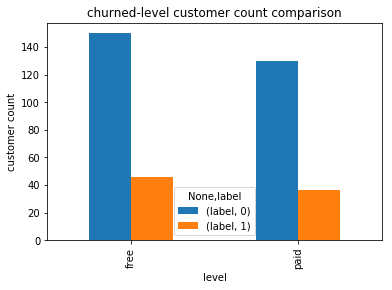

In [31]:
use_level_count = labeled_df.groupby('userId', 'level', 'label').count()
use_level_count_pd  = use_level_count.select("userId", "level", 'label').toPandas()
use_level_count_pd[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned-level customer count comparison')
plt.ylabel('customer count');

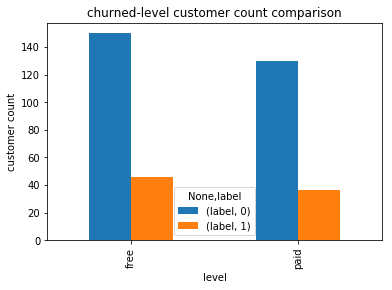

In [32]:
use_level_count_pd[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned-level customer count comparison')
plt.ylabel('customer count');

The above plot shows we more customers on teh free tier. Number of churned users in the free tier is also higher.

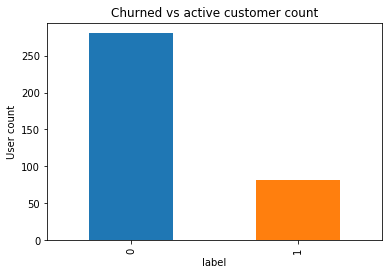

In [33]:
use_level_count_pd.label.value_counts().plot(kind='bar');
plt.ylabel('User count')
plt.xlabel('label')
plt.title('Churned vs active customer count');

In [34]:
# count downgrade events per user
downgrade_events_user = labeled_df.filter(psqf.col('page') == 'Downgrade').groupBy('label','page').count()
downgrade_events_user.show(2)

+-----+---------+-----+
|label|     page|count|
+-----+---------+-----+
|    1|Downgrade|  337|
|    0|Downgrade| 1718|
+-----+---------+-----+



Number of Downgrades is lower for churned users

In [35]:
labeled_df.groupBy('userId','label','gender').count().select('label', 'gender').groupBy('label','gender').count().show()

+-----+------+-----+
|label|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|  null|    1|
|    1|     M|   32|
|    0|     F|   84|
|    1|     F|   20|
+-----+------+-----+



Hard to tell here if Gender has an any influence on customer churn.

### Which of those features can be useful to define churn?
- ts: we can get information like total number of hours a customer played songs
- song: we can get the number of songs a customer played
- from **page** column we can find the number of ThumbsUp, ThumbsDown, and Downgrades

# Data Preprocessing
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Number of songs each user played

In [36]:
songsplayed = labeled_df.where(psqf.col('song')!='null').groupby("userId").agg(psqf.count(psqf.col('song')).alias('SongsPlayed')).orderBy('userId')
songsplayed.show(5)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
+------+-----------+
only showing top 5 rows



### Number of distinct hour counts  a user logged in the system

In [37]:
hours_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d-%H'))
hours_df  = labeled_df.select('userId', 'ts').withColumn('hour', hours_udf(psqf.col('ts')))
hours_df.show(5)

+------+-------------+-------------+
|userId|           ts|         hour|
+------+-------------+-------------+
|100010|1539003534000|2018-10-08-12|
|100010|1539003736000|2018-10-08-13|
|100010|1539003932000|2018-10-08-13|
|100010|1539003933000|2018-10-08-13|
|100010|1539004195000|2018-10-08-13|
+------+-------------+-------------+
only showing top 5 rows



In [38]:
hour_count_df = hours_df.where(psqf.col('userId')!='null').groupby('userId').agg((psqf.countDistinct(psqf.col('hour'))).alias("HourCount")).orderBy('userId')
hour_count_df.show(5)

+------+---------+
|userId|HourCount|
+------+---------+
|      |     1306|
|    10|       51|
|   100|      218|
|100001|       14|
|100002|       18|
+------+---------+
only showing top 5 rows



### Thumbs Up and Thumbs Down counts:
A user having a lot of thumbs down could be an indication of the users disastisfaction with song recommendations from Sparkify while a more thumbs up ( likes) by a user indicates user is happy with song recommendations.

In [39]:
# filter out rows with userId == null
labeled_df = labeled_df.where(psqf.col('userId')!='null')
labeled_df.show(5)

+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+
|userId|label|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|        ts_datetime|
+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+
|100010|    0|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|2018-10-08 12:58:54|
|100010|

In [40]:
thumbsup_count = labeled_df.where((psqf.col('page')=='Thumbs Up') &(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount')).orderBy('userId')
thumbsup_count.show(5, False)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|10    |37           |
|100   |148          |
|100001|8            |
|100002|5            |
|100003|3            |
+------+-------------+
only showing top 5 rows



In [41]:
thumbsdown_count = labeled_df.where((psqf.col("page")=='Thumbs Down')&(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount')).orderBy('userId')
thumbsdown_count.show(5)

+------+---------------+
|userId|thumbsDownCount|
+------+---------------+
|    10|              4|
|   100|             27|
|100001|              2|
|100004|             11|
|100005|              3|
+------+---------------+
only showing top 5 rows



In [42]:
## Join all the features
features_df = churn_event.join(songsplayed, "userId").\
join(hour_count_df, "userId").join(thumbsup_count, "userId").join(thumbsdown_count, "userId")

In [43]:
features_df.show(5)

+------+-----+-----------+---------+-------------+---------------+
|userId|label|SongsPlayed|HourCount|thumbsUpCount|thumbsDownCount|
+------+-----+-----------+---------+-------------+---------------+
|100010|    0|        275|       26|           17|              5|
|200002|    0|        387|       32|           21|              6|
|   124|    0|       4079|      306|          171|             41|
|    51|    1|       2111|      156|          100|             21|
|     7|    0|        150|       18|            7|              1|
+------+-----+-----------+---------+-------------+---------------+
only showing top 5 rows



In [44]:
assembler = VectorAssembler(inputCols=["SongsPlayed", "HourCount", "thumbsUpCount", "thumbsDownCount"], outputCol="rawFeatures")
features_df = assembler.transform(features_df)
features_df.select('label', 'rawFeatures').show(4)

+-----+--------------------+
|label|         rawFeatures|
+-----+--------------------+
|    0|[275.0,26.0,17.0,...|
|    0|[387.0,32.0,21.0,...|
|    0|[4079.0,306.0,171...|
|    1|[2111.0,156.0,100...|
+-----+--------------------+
only showing top 4 rows



In [45]:
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(features_df)
features_df = scalerModel.transform(features_df)

In [46]:
input_data = features_df.withColumn('label', psqf.col('label').cast(psqt.IntegerType())).select('label', 'features')
input_data.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.24639992057147...|
|    0|[0.34675188822240...|
+-----+--------------------+
only showing top 2 rows



# Implementation
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### split datest into train, validation and test sets
- train model using training dataset
- tune model using validation dataset
- test best model selected based on validation dataset on test dataset.

In [47]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)

In [48]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(input_data)

In [49]:
# Split the data into training and test sets (since dataset is imbalanced)
(trainingData, tempData) = input_data.randomSplit([0.6, 0.4])
(validationData, testData) = tempData.randomSplit([0.5, 0.5])

In [50]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [51]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [52]:
# Make predictions.
predictions = model.transform(validationData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             1|    0|[0.24639992057147...|
|             0|    0|[0.34675188822240...|
|             0|    0|[3.65478282185840...|
|             0|    0|[1.42015954220288...|
|             1|    0|[0.33779189111071...|
+--------------+-----+--------------------+
only showing top 5 rows

Validation Error = 0.285714
RandomForestClassificationModel (uid=RandomForestClassifier_5e58d1bc9733) with 10 trees


In [53]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.665306


# Refinement

Let's tune our model to have a better performance.

In [54]:
rfc = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rfc, labelConverter])
param_grid = ParamGridBuilder().addGrid(rfc.numTrees, [10, 15]).addGrid(rfc.maxDepth, [2, 5]).build()
cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps = param_grid, 
                    evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=3)

best_model = cv.fit(trainingData)

In [55]:
def evaluate_model(model, data):
    """
    Make prediction and evaluate model.
    Parameters
    -----------
        model: model object
    returns
    -------
        None
    """
    predictions = model.transform(data)

    # Select example rows to display.
    predictions.select("predictedLabel", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Error = %g" % (1.0 - accuracy))
    f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
    f1_score = f1_score_evaluator.evaluate(predictions)
    print("F1 score = %g" % (f1_score))

In [56]:
evaluate_model(model=best_model, data=validationData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             1|    0|[0.24639992057147...|
|             0|    0|[0.34675188822240...|
|             0|    0|[3.65478282185840...|
|             0|    0|[1.42015954220288...|
|             0|    0|[0.33779189111071...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.261905
F1 score = 0.647097


In [57]:
evaluate_model(model=best_model, data=testData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.13439995667535...|
|             0|    1|[2.54553517943116...|
|             0|    0|[1.00799967506513...|
|             1|    1|[0.33779189111071...|
|             0|    1|[0.19174393819016...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.133333
F1 score = 0.847863


# Results
We have analysed the sparkify dataset and come up with new features to predict churn. We then created a machine learning model and tuned it to improve its performance. We achieved an accuracy score of - and F1 score of - on the test dataset. 

# Conclusion
We are able to achieve an accuracy score of -- and F1 score of -- on the test dataset using the tuned Random Forest algorithm. The model peformance can be further improved by creating additional features and includiding some of the features that I have left out for this analysis. The model should also be tested using samples from the left out big dataset which hasn't been used for this analysis. Once we are satified with the result, a large scale of the model can be implemented on the cloud.